# Libraries Import

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from pysal.lib import weights
import json

C:\Users\Radek\AppData\Roaming\Python\Python39\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


ModuleNotFoundError: No module named 'pysal'

# Furto/Roubo 2020 Analysis

## Data parsing

In [127]:
df_coord_2020 = pd.read_csv('../data/pcpr/furto_roubo_2020_coordenadas.csv')

df_coord_2020['data_fato'] = pd.to_datetime(df_coord_2020['data_fato'])
df_coord_2020['bairro'] = df_coord_2020['bairro'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_coord_2020['bairro'] = df_coord_2020['bairro'].apply(lambda x: "CIDADE INDUSTRIAL DE CURITIBA" if "CIDADE INDUSTRIAL" in x else x)

df_coord_2020.tail(5)

,id,data_fato,tipo_ocorrencia,geox,geoy,bairro
32061,13867,2020-12-31,Furto e Roubo,-49.309582,-25.469658,CENTRO
32062,4002,2020-12-31,Furto e Roubo,-49.250787,-25.537457,SEMINARIO
32063,6214,2020-12-31,Furto e Roubo,-49.256328,-25.501776,VILA IZABEL
32064,6233,2020-12-31,Furto e Roubo,-49.246676,-25.556869,VILA IZABEL
32065,8818,2020-12-31,Furto e Roubo,-49.289549,-25.489066,PINHEIRINHO


## Check occurrences year

In [21]:
pd.DataFrame(pd.DatetimeIndex(df_coord_2020['data_fato']).year).value_counts()

data_fato
2020         32066
dtype: int64

## Check occurences type

In [22]:
df_coord_2020['tipo_ocorrencia'].value_counts()

Furto e Roubo    32066
Name: tipo_ocorrencia, dtype: int64

## Occurrences per district visualization

In [66]:
px.histogram(df_coord_2020, x='bairro').update_xaxes(categoryorder='total descending').show()

## Spots of occurences

In [67]:
px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_mapbox(df_coord_2020,
                        lat=df_coord_2020.geoy,
                        lon=df_coord_2020.geox,
                        hover_name="bairro",
                        color="bairro",
                        zoom=1)
fig.show()

## Districts shapes parsing

In [128]:
districts = gpd.read_file('../data/divisa_bairros_cleaned.geojson')

districts.rename(columns={'NOME':'bairro'}, inplace=True)

districts['bairro'] = districts['bairro'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

districts.tail()

,OBJECTID,CODIGO,TIPO,bairro,FONTE,CD_REGIONA,NM_REGIONA,SHAPE_AREA,SHAPE_LEN,geometry
70,69,31,DIVISA DE BAIRROS,VISTA ALEGRE,Decreto Municipal 774 / 1975,5,REGIONAL SANTA FELICIDADE,3.698848e+06,10150.085813,"POLYGON Z ((-49.30364 -25.39631 0.00000, -49.3..."
71,70,60,DIVISA DE BAIRROS,SAO BRAZ,Decreto Municipal 774 / 1975,5,REGIONAL SANTA FELICIDADE,5.060315e+06,11698.605208,"POLYGON Z ((-49.34487 -25.40427 0.00000, -49.3..."
72,71,48,DIVISA DE BAIRROS,SAO JOAO,Decreto Municipal 774 / 1975,5,REGIONAL SANTA FELICIDADE,3.036122e+06,8110.401859,"POLYGON Z ((-49.30524 -25.38436 0.00000, -49.3..."
73,74,47,DIVISA DE BAIRROS,CASCATINHA,Decreto Municipal 774 / 1975,5,REGIONAL SANTA FELICIDADE,2.182142e+06,8730.820987,"POLYGON Z ((-49.30568 -25.40558 0.00000, -49.3..."
74,75,63,DIVISA DE BAIRROS,SANTA FELICIDADE,Decreto Municipal 774 / 1975,5,REGIONAL SANTA FELICIDADE,1.217599e+07,19182.712064,"POLYGON Z ((-49.31878 -25.39482 0.00000, -49.3..."


## Occurrences per district creation and manipulation

In [129]:
df_occurrences_district = pd.DataFrame(df_coord_2020['bairro'].value_counts().reset_index().rename(columns={"index":"bairro", "bairro":"ocorrencias"}))

df_occurrences_district['bairro'] = df_occurrences_district['bairro'].apply(lambda x: "CIDADE INDUSTRIAL DE CURITIBA" if "CIDADE INDUSTRIAL" in x else x)

df_occurrences_district.head()

,bairro,ocorrencias
0,CENTRO,3786
1,CIDADE INDUSTRIAL DE CURITIBA,2022
2,SITIO CERCADO,1543
3,CAJURU,1240
4,AGUA VERDE,1196


In [132]:
db = gpd.GeoDataFrame(districts.merge(df_occurrences_district), crs=districts.crs).to_crs(epsg=3857)[['OBJECTID', 'bairro', 'ocorrencias', 'geometry']].dropna()
db

,OBJECTID,bairro,ocorrencias,geometry
0,20,AGUA VERDE,1196,"POLYGON Z ((-5484832.641 -2931491.254 0.000, -..."
1,22,JARDIM SOCIAL,108,"POLYGON Z ((-5480252.197 -2926985.265 0.000, -..."
2,23,XAXIM,727,"POLYGON Z ((-5484145.981 -2935829.003 0.000, -..."
3,5,JARDIM DAS AMERICAS,364,"POLYGON Z ((-5480008.382 -2933834.210 0.000, -..."
4,9,GUAIRA,315,"POLYGON Z ((-5486089.564 -2934441.648 0.000, -..."
...,...,...,...,...
70,69,VISTA ALEGRE,86,"POLYGON Z ((-5488456.296 -2924500.831 0.000, -..."
71,70,SAO BRAZ,269,"POLYGON Z ((-5493045.709 -2925482.796 0.000, -..."
72,71,SAO JOAO,26,"POLYGON Z ((-5488634.469 -2923029.086 0.000, -..."
73,74,CASCATINHA,17,"POLYGON Z ((-5488683.456 -2925644.261 0.000, -..."


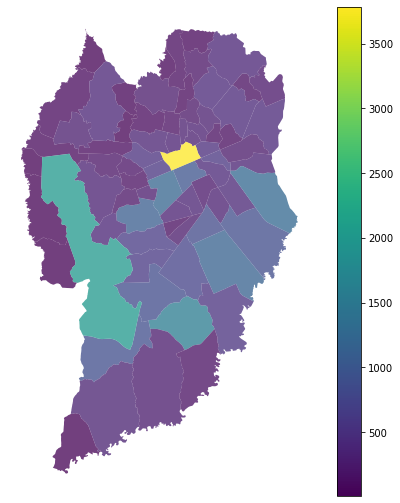

In [133]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    column='ocorrencias', 
    cmap='viridis', 
    # scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75, 
    legend=True,
    # legend_kwds={"loc": 2},
    ax=ax
)
# contextily.add_basemap(
#     ax, 
#     crs=db.crs, 
#     source=contextily.providers.Stamen.TerrainBackground
# )
ax.set_axis_off()

In [ ]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = 'R'